In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# pip install tensorflow
import tensorflow as tf
import keras
from keras import layers

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

In [2]:
df = pd.read_csv('train.csv')
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [3]:
df.columns

Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'price_range'],
      dtype='object')

In [4]:
corr_matrix = df.corr()['price_range']
corr_matrix = corr_matrix.sort_values(ascending=False)

In [5]:
corr_matrix

price_range      1.000000
ram              0.917046
battery_power    0.200723
px_width         0.165818
px_height        0.148858
int_memory       0.044435
sc_w             0.038711
pc               0.033599
three_g          0.023611
sc_h             0.022986
fc               0.021998
talk_time        0.021859
blue             0.020573
wifi             0.018785
dual_sim         0.017444
four_g           0.014772
n_cores          0.004399
m_dep            0.000853
clock_speed     -0.006606
mobile_wt       -0.030302
touch_screen    -0.030411
Name: price_range, dtype: float64

In [6]:
removables = ['touch_screen', 'mobile_wt', 'clock_speed', 'm_dep', 'four_g', 'three_g', 'wifi', 'blue']

In [7]:
df = df.drop(removables, axis=1)

In [8]:
df.head()

,battery_power,dual_sim,fc,int_memory,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,price_range
0,842,0,1,7,2,2,20,756,2549,9,7,19,1
1,1021,1,0,53,3,6,905,1988,2631,17,3,7,2
2,563,1,2,41,5,6,1263,1716,2603,11,2,9,2
3,615,0,0,10,6,9,1216,1786,2769,16,8,11,2
4,1821,0,13,44,2,14,1208,1212,1411,8,2,15,1


In [9]:
df['price_range'] = df['price_range'].replace({0: "1: Cheap", 1: "2: Avg-", 2: "3: Avg+", 3: "4: Expensive"})

In [10]:
# everything else except the target variable
X = df.drop("price_range", axis=1)

# have only the target variable here (dependent variable)
y_temp = df['price_range']

# since we are doing classification, we have to process our target values with an encoder
# and convert them into a categorical TensorFlow/Keras -format 
le = LabelEncoder()
y_enc = le.fit_transform(y_temp)

# Converting the label into a matrix form
y = tf.keras.utils.to_categorical(y_enc)

In [11]:
y

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [12]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# convert all continuous variables to integer,
# and convert all negative numbers to 0
X_cat = X.astype(int)
X_cat = X_cat.clip(lower=0)

# initialize chi2 and SelectKBest
# Note: chi2 -test is a very common test
# in statistics and quantitative analysis
# basically it studies the data whether variables are related
# or independent of each other
chi_2_features = SelectKBest(chi2, k=len(X_cat.columns))

# fit our data to the SelectKBest
best_features = chi_2_features.fit(X_cat,y.astype(int))

# use decimal format in table print later
pd.options.display.float_format = '{:.2f}'.format

# wrap it up, and show the results
# the higher the score, the more effect that column has on price
df_features = pd.DataFrame(best_features.scores_)
df_columns = pd.DataFrame(X_cat.columns)
f_scores = pd.concat([df_columns,df_features],axis=1)
f_scores.columns = ['Features','Score']
f_scores.sort_values(by='Score',ascending=False)

,Features,Score
8,ram,931267.52
6,px_height,17363.57
0,battery_power,14129.87
7,px_width,9810.59
3,int_memory,89.84
10,sc_w,16.48
11,talk_time,13.24
2,fc,10.14
9,sc_h,9.61
5,pc,9.19


In [13]:
# usual train-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.35)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5)

In [14]:
# save the categories into a list
categories = list(np.unique(df['price_range']))
print(categories)

# note: this only works if the categories are ordinal integers
# if you wish to keep the order of the text labels, you might want to do
# something like this before so that the number is also carried with
# the rest of the code

['1: Cheap', '2: Avg-', '3: Avg+', '4: Expensive']


In [15]:
model = keras.Sequential(
    [
        layers.BatchNormalization(input_shape=(len(X.columns),)),
        layers.Dense(16, activation="relu", kernel_regularizer=keras.regularizers.l1(l=0.1)),
        layers.Dense(32, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(8, activation="relu"),
        layers.Dense(len(categories), activation="softmax")
    ]
)

# compile the model, this time we use categorical crossentropy for loss -function
# and we also measure the accuracy of our model in the metrics
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 12)                48        
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 16)                208       
                                                                 
 dense_1 (Dense)             (None, 32)                544       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                      

In [16]:
# adjust epochs as you see fit
model.fit(x=X_train, y=y_train, epochs=300, validation_data=(X_val, y_val))

Epoch 1/300


41/41 [==============================] - 4s 15ms/step - loss: 5.4586 - accuracy: 0.2254 - val_loss: 5.0618 - val_accuracy: 0.1914
Epoch 2/300
41/41 [==============================] - 0s 6ms/step - loss: 4.7046 - accuracy: 0.2277 - val_loss: 4.3629 - val_accuracy: 0.2257
Epoch 3/300
41/41 [==============================] - 0s 6ms/step - loss: 4.0705 - accuracy: 0.2585 - val_loss: 3.7770 - val_accuracy: 0.2886
Epoch 4/300
41/41 [==============================] - 0s 6ms/step - loss: 3.5087 - accuracy: 0.2800 - val_loss: 3.2421 - val_accuracy: 0.3886
Epoch 5/300
41/41 [==============================] - 0s 8ms/step - loss: 3.0071 - accuracy: 0.3485 - val_loss: 2.7705 - val_accuracy: 0.4257
Epoch 6/300
41/41 [==============================] - 0s 11ms/step - loss: 2.5519 - accuracy: 0.4200 - val_loss: 2.3134 - val_accuracy: 0.5714
Epoch 7/300
41/41 [==============================] - 0s 9ms/step - loss: 2.1030 - accuracy: 0.4908 - val_loss: 1.8775 - val_accuracy: 0.6286
Epoch 8/3

<Axes: >

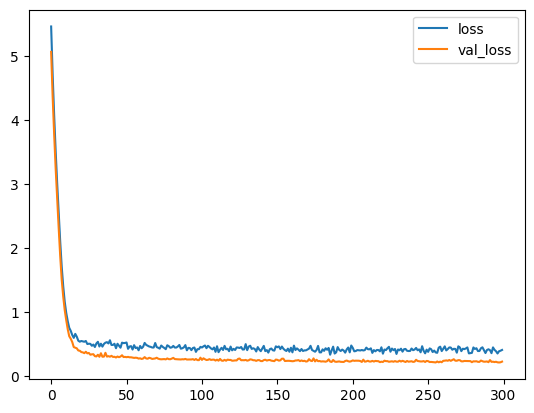

In [17]:
loss_df = pd.DataFrame(model.history.history)
loss_df[['loss', 'val_loss']].plot()

<Axes: >

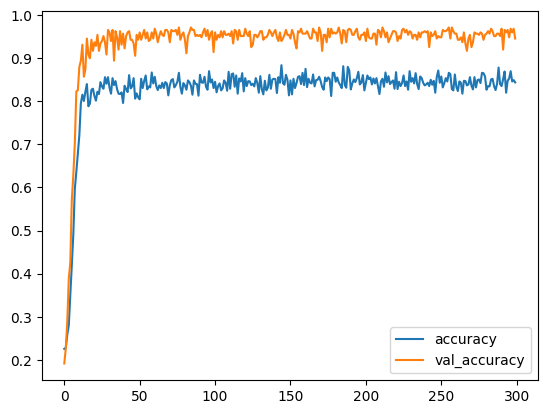

In [18]:
loss_df[['accuracy', 'val_accuracy']].plot()

In [19]:
# compare the final model loss/accuracy/evaluation values
# the values should again match mostly
print("Test data evaluation:")
print(model.evaluate(X_test, y_test, verbose=0))
print("\nTrain data evaluation:")
print(model.evaluate(X_train, y_train, verbose=0))

Test data evaluation:
[0.22693628072738647, 0.9314285516738892]

Train data evaluation:
[0.2298387736082077, 0.942307710647583]


In [20]:
# get predictions and convert with argmax() to get categories 
# instead of raw probabilities
test_predictions = model.predict(X_test)
test_predictions = np.argmax(test_predictions, axis=1)

# convert also y-test -values with argmax
y_test = np.argmax(y_test, axis=1)

11/11 [==============================] - 0s 5ms/step


<Axes: >

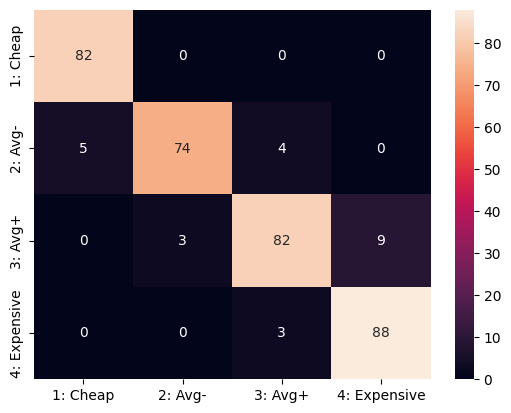

In [21]:
# confusion matrix
# sns.heatmap(confusion_matrix(y_test, test_predictions), annot=True, fmt='g')
sns.heatmap(confusion_matrix(y_test, test_predictions), xticklabels=categories, yticklabels=categories, annot=True, fmt='g')

In [22]:
# print the classification report based on true values and predictions
print(classification_report(y_test, test_predictions))

# get overall accuracy of the model and print it
acc = accuracy_score(y_test, test_predictions)
print("\nModel overall accuracy: {:.2f}%".format(acc * 100))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        82
           1       0.96      0.89      0.92        83
           2       0.92      0.87      0.90        94
           3       0.91      0.97      0.94        91

    accuracy                           0.93       350
   macro avg       0.93      0.93      0.93       350
weighted avg       0.93      0.93      0.93       350


Model overall accuracy: 93.14%


In [23]:
# In multi category classification , AUC values are often interpreted as follows: 
# 0.5-0.6 (failed)
# 0.6-0.7 (worthless)
# 0.7-0.8 (poor)
# 0.8-0.9 (good)
# > 0.9 (excellent)

# get ROC-AUC -score
roc_auc_score(y, model.predict(X), multi_class="ovr")

63/63 [==============================] - 0s 3ms/step


0.9971116666666666

In [24]:
 # let's try with some new imaginary data
# modify this as needed regarding your own dataset
tester_row = {
    'battery_power': 1000, 
    'dual_sim': 0,
    'fc': 4, 
    'int_memory': 4, 
    'n_cores': 1, 
    'pc': 4,
    'px_height': 900,
    'px_width': 1200, 
    'ram': 2096, 
    'sc_h': 7, 
    'sc_w': 4, 
    'talk_time': 12
}

# convert to pandas-format
tester_row = pd.DataFrame([tester_row])
result = model.predict(tester_row)[0]
print(result.round(3))

result_index = np.argmax(result)
print(result_index)

# print the actual name with this index
result_text = categories[result_index]

# print the result
print(f"Predicted price range: {result_text}")

1/1 [==============================] - 0s 53ms/step
[0.002 0.738 0.259 0.   ]
1
Predicted price range: 2: Avg-


In [25]:
model.save('mobilephoneprice.keras')